<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">ARIMA Models (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>
<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2><span style="background-color: initial; font-family: Gotham-Rounded-Bold; font-size: 24px;">ARIMA Models (Practice)</span></h2>
<p></p>
<p>Continue working on the dataset from the model orders practice assignment. This time, you will only work with one time series  (ts_5)  to build, fit, and evaluate a model based on the orders you selected in the previous assignment.  </p>
<p>Previously we,</p>
<ul><li>Checked for stationarity <ul><li>Determine if differencing is needed and decide the value for d.</li><li>If the data was not stationary and needed differencing, save a copy of the stationary/differenced data it for EDA.</li></ul></li><li>Viewed the ACF/PACF plots for the stationary data to determine q and p.</li></ul>
<p>New</p>
<ul><li>For the ts_5 time series:</li><li>Split the data into train and test so that the test is 10 weeks (test_size = 10)</li><li>Visualize the train test split</li><li>Fit an ARIMA model, using the model orders (p,d,q) you determined based on your EDA. (1,1,1)</li><li>Check the model summary and diagnostic plots for warning signs</li><li>Extract a forecast from the model</li><li>Visualize the true versus forecasted values.</li><li>Evaluate with regression metrics, including MAPE.</li><li>Use a loop to try various orders (try 0-2 for p and 0-2 for q)</li><li>State the model you select as your final model.</li><li>Submit Below</li></ul>
<p></p>
<p>Solution</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [40]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
df = pd.read_csv('Data/example_time_series.csv')
df

,Date,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6
0,2020-01-05,0.422207,-0.334830,-0.194485,0.304119,0.335330,0.628650
1,2020-01-12,-0.455290,-0.343508,-0.649775,0.385431,0.253175,-0.062857
2,2020-01-19,0.914767,-0.080714,0.264993,0.987436,0.202251,0.474599
3,2020-01-26,0.562761,0.010582,0.827754,0.830760,0.137298,-0.591919
4,2020-02-02,-0.649239,-0.088101,0.178515,-0.827785,0.305798,-0.372528
...,...,...,...,...,...,...,...
195,2023-10-01,-0.180337,0.034521,-3.690399,0.698037,0.730687,-0.901562
196,2023-10-08,-0.607009,-0.126291,-4.297408,-1.720225,0.582334,0.515721
197,2023-10-15,0.616274,-0.242378,-3.681135,2.085681,0.703901,0.801864
198,2023-10-22,-0.443541,-0.226903,-4.124676,-1.755198,0.634631,0.894529


In [6]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# We have weekly data so we will set our frequency to W
df.index.freq= "W"

In [7]:
# Split the dataframe into 6 different time series
ts_1 = df['ts_1']
ts_2 = df['ts_2']
ts_3 = df['ts_3']
ts_4 = df['ts_4']
ts_5 = df['ts_5']
ts_6 = df['ts_6']

## ts_5

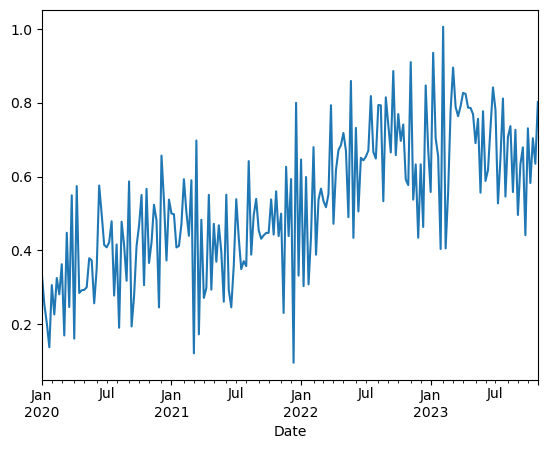

In [22]:
# Plot raw data
ts_5.plot();

In [23]:
# is it stationary?
get_adfuller_results(ts_5)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.085917,4,195,0.250215,0.05,False


In [24]:
# raw data is not stationary, so we will apply differcing
ts_5_diff = ts_5.diff().dropna()
get_adfuller_results(ts_5_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.465469,3,195,0.0,0.05,True


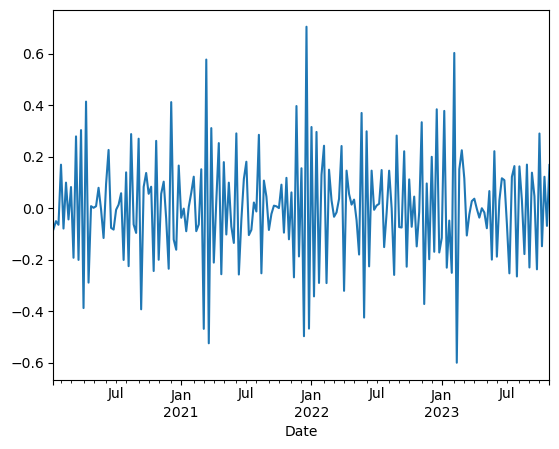

In [25]:
# Plot differenced data
ts_5_diff.plot();

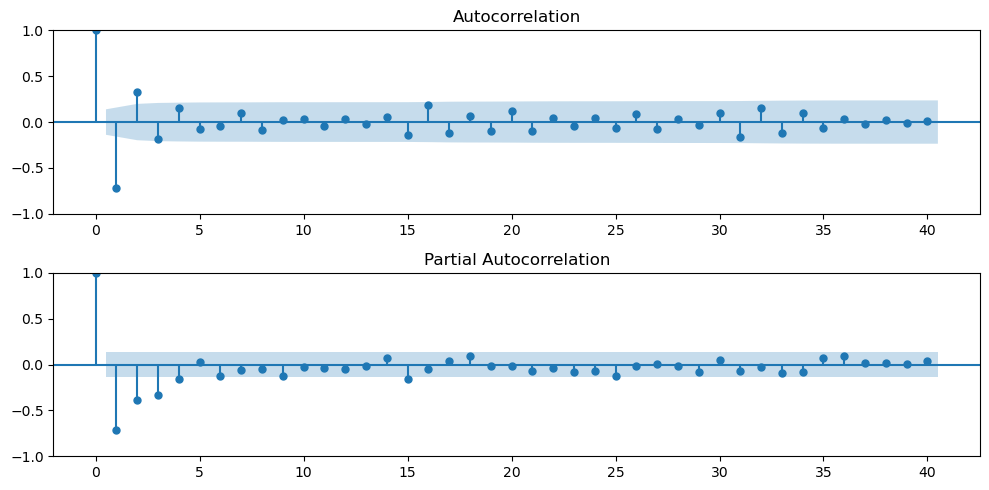

In [26]:
# Use differenced (stationary) data to plot ACF and PACF
plot_acf_pacf(ts_5_diff);

Interpret
- Here we see both the PACF and the ACF as trailing
- Thus we can conclude that this is an ARMA model, BUT we cannot conclude p and q
- We will start with (1,1,1)
- We could then increase the p or q and see if the coefficient is sig or not when the model is fit

# MODELING ts_5

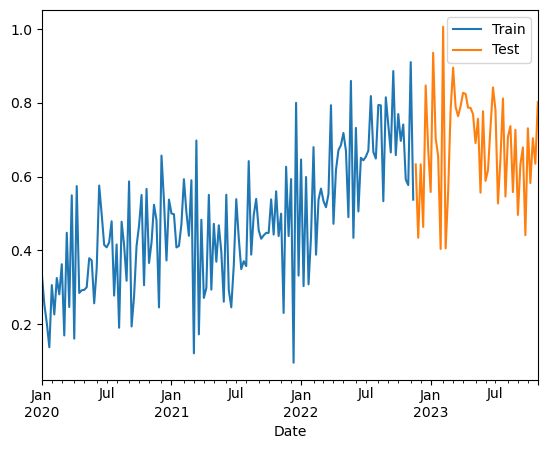

In [45]:
from pmdarima.model_selection import train_test_split
# tts
train, test = train_test_split(ts_5, test_size = .25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [46]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary
 
q = 1  # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [36]:
# Obtain model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ts_5   No. Observations:                  150
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 108.784
Date:                Mon, 25 Sep 2023   AIC                           -211.567
Time:                        17:11:02   BIC                           -202.555
Sample:                    01-05-2020   HQIC                          -207.906
                         - 11-13-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5376      0.079     -6.801      0.000      -0.693      -0.383
ma.L1         -0.7396      0.067    -10.987      0.000      -0.872      -0.608
sigma2         0.0134      0.002      8.735      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 2.13
Prob(Q):                              0.59   Prob(JB):                         0.35
Heteroskedasticity (H):               1.04   Skew:                            -0.27
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

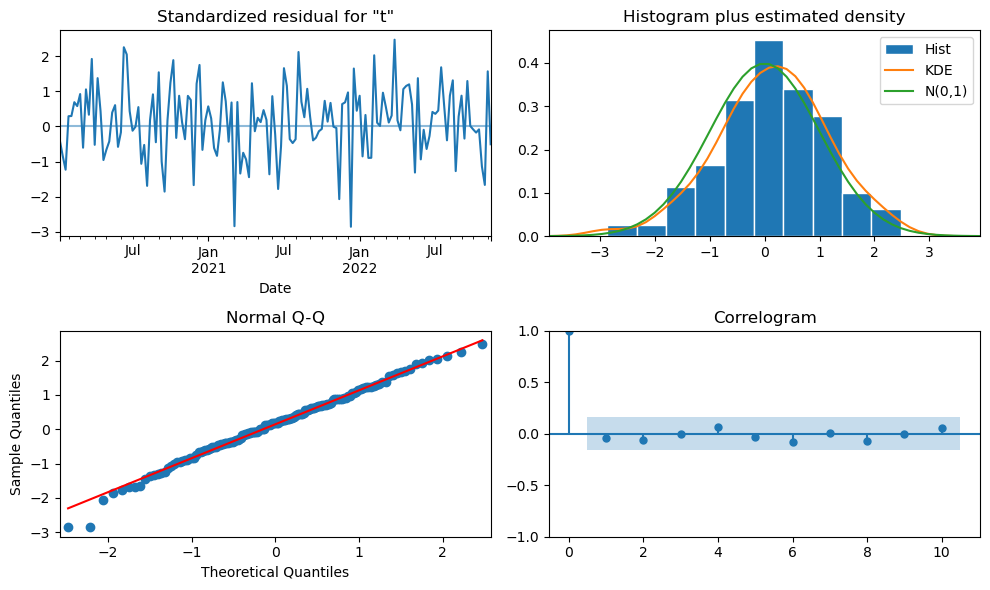

In [47]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

We don't see any warning signs in our summary or diagnostic plots

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.113
- MSE = 0.019
- RMSE = 0.137
- R^2 = 0.001
- MAPE = 18.53%


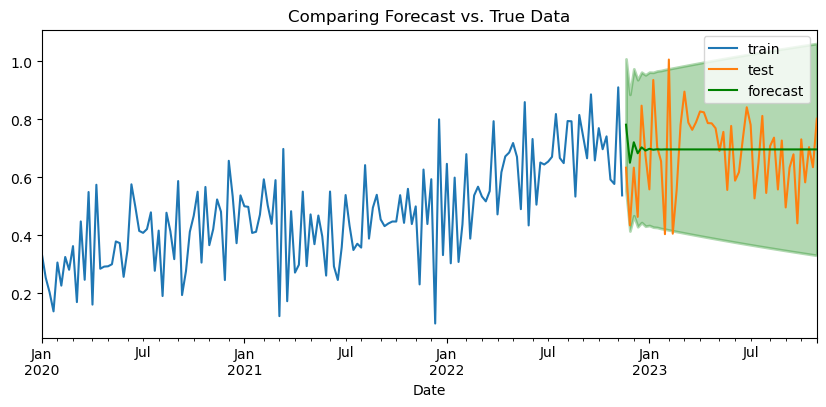

In [48]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [ ]:
# Loop through variations of model and consider alternatives

In [51]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [52]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) -40.06335016756122
(0, 1, 1) -173.1300553306727


C:\Users\brend\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 2) -206.0503684703179
(1, 1, 0) -162.16456438282398
(1, 1, 1) -211.56720277410756
(1, 1, 2) -210.0168213685581
(2, 1, 0) -186.62300788559307
(2, 1, 1) -209.85361982166276
(2, 1, 2) -208.21203092035717
Best AIC: -211.56720277410756
Best pdq: (1, 1, 1)


In this case, the loop resulted in the same orders we predicted manually, so we will choose our final model as ARIMA (1,1,1)